# PARTE III - Desafio Modelo Preditivo
Agora que limpamos o dataset e fizemos a análise exploratória dos dados, está na hora de construir o modelo preditivo.

## Objetivo Principal
Desenvolver um **modelo preditivo** capaz de estimar a probabilidade de inadimplência de cobranças mensais feitas aos clientes.

A **inadimplência** é definida da seguinte forma:
> Um pagamento é considerado inadimplente se for realizado com **5 dias ou mais de atraso** em relação à data de vencimento.

As previsões devem conter apenas a **probabilidade de inadimplência**.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importando o dataset do teste (submissão)
teste = pd.read_csv('docs/dataset_teste.csv', sep=',')

# Importando o dataset para treinamento  
df_treino = pd.read_csv("docs/dataset_limpo.csv", sep = ",")

In [3]:
display(df_treino)
display(teste)

,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,PJ_ou_PF,SEGMENTO_INDUSTRIAL_Comércio,SEGMENTO_INDUSTRIAL_Indústria,SEGMENTO_INDUSTRIAL_Serviços,Tam_Empresa,INADIMPLENCIA,Mes_Emissao_Documento,Dia_Emissao_Documento,Mes_Vencimento,Dia_Vencimento
0,35516.41,6.99,217640.0,115.0,1,0,0,1,0,0,8,17,9,6
1,17758.21,6.99,217640.0,115.0,1,0,0,1,0,0,8,19,9,10
2,17431.96,6.99,217640.0,115.0,1,0,0,1,0,0,8,26,9,17
3,1341.00,6.99,217640.0,115.0,1,0,0,1,0,1,8,30,10,5
4,21309.85,6.99,217640.0,115.0,1,0,0,1,0,0,8,31,9,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77262,89980.00,5.99,280343.0,161.0,1,1,0,0,0,0,6,30,7,16
77263,42239.00,5.99,235315.0,87.0,1,0,1,0,2,0,6,30,8,16
77264,20921.50,5.99,100006.0,122.0,1,0,0,1,2,0,6,30,7,16
77265,90231.05,6.99,234489.0,115.0,1,0,0,1,1,0,6,30,7,16


,ID_CLIENTE,SAFRA_REF,VALOR_A_PAGAR,TAXA,Mes_Emissao_Documento,Dia_Emissao_Documento,Mes_Vencimento,Dia_Vencimento
0,5058298901476893676,2021-07,11204.75,4.99,7,14,8,4
1,274692171162531764,2021-07,60718.50,5.99,7,8,8,23
2,274692171162531764,2021-07,60718.50,5.99,7,11,8,25
3,274692171162531764,2021-07,62250.00,5.99,7,16,8,30
4,465309249432033993,2021-07,26593.95,6.99,7,5,7,30
...,...,...,...,...,...,...,...,...
12270,705648002974742140,2021-11,47010.00,6.99,11,25,12,13
12271,4993499380140734678,2021-11,122875.35,8.99,11,25,12,13
12272,4614484019183480654,2021-11,302200.00,5.99,11,26,9,30
12273,1299146298565441811,2021-11,143791.85,5.99,11,26,12,13


É essencial que o número de colunas (características ou features) seja exatamente o mesmo nas bases de dados de treino e teste.

Isso é um requisito fundamental para a maioria dos algoritmos de machine learning por várias razões:
1. **Consistência do Modelo**: O modelo é treinado para aprender um padrão específico com base em um conjunto fixo de entradas (colunas). Para fazer uma previsão, ele espera receber exatamente as mesmas entradas na mesma ordem.
2. **Mapeamento de Características**: Se a base de teste tiver uma coluna a menos ou a mais, o algoritmo não saberá como mapear os dados de entrada para os pesos e vieses que aprendeu durante o treinamento.
3. **Integridade dos Dados**: Ambas as bases devem representar a mesma estrutura de dados do problema que você está tentando resolver.

O que deve ser igual:
- **Número de colunas**: Exatamente o mesmo.
- **Nomes das colunas**: Devem coincidir para garantir que o algoritmo use os dados corretos (ex: a coluna 'idade' na base de treino deve ser a 'idade' na base de teste).
- **Ordem das colunas**: A maioria das bibliotecas de machine learning requer que a ordem seja idêntica. 

Irei abordar quatro modelos de Machine Learning:
1. Regressão Logística
2. Random Forest
3. Árvore de Decisão
4. KNeighborsClassifier

Vamos ver qual se sai melhor neste caso.

Antes, vamos preparar o que será utilizado em treino e teste. 

**ATENÇÃO**: No primeiro momento irei validar os modelos utilizados com base no dataset `df_treino`, depois de avaliar os modelos irei implementar o que tiver melhor resultado no dataset de `teste`. 

In [4]:
# Divisão entre treino e teste
from sklearn.model_selection import train_test_split

# Divisão entre target e o que será usado no modelo
X = df_treino.drop(['RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'PJ_ou_PF', 'SEGMENTO_INDUSTRIAL_Comércio', 'SEGMENTO_INDUSTRIAL_Indústria', 'SEGMENTO_INDUSTRIAL_Serviços', 'Tam_Empresa',
                            'INADIMPLENCIA'], axis=1)
y = df_treino['INADIMPLENCIA']

# Divisão entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
# Import dos modelos e metrícas de avaliação
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import classification_report, RocCurveDisplay, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

Funções que usarei: 

In [6]:
# Função de treinamento dos modelos
def treinar_modelo(modelo, X_train, y_train, X_test, y_test):
    """
    Treina o modelo, calcula previsões e retorna o modelo treinado e suas métricas.
    """
    # Treino
    modelo.fit(X_train, y_train)

    # Previsões
    y_pred = modelo.predict(X_test)

    # Acurácia
    acuracia = accuracy_score(y_test, y_pred)

    print(f"Acurácia do modelo {modelo.__class__.__name__}: {acuracia:.4f}")

    return modelo, y_pred, acuracia


# Função para avaliação dos modelos
def avaliar_modelo(modelo, X_test, y_test, titulo="Resultados do Modelo"):
    # ---- PREVISÕES ----
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1]  # probabilidade da classe 1

    # ---- MATRIZ DE CONFUSÃO ----
    conf_matrix = confusion_matrix(y_test, y_pred)

    # ---- CURVA ROC / AUC ----
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # --------- FIGURA COM SUBPLOTS ----------
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(titulo, fontsize=16, fontweight='bold')

    # --------- SUBPLOT 1: MATRIZ DE CONFUSÃO ----------
    ConfusionMatrixDisplay(conf_matrix).plot(ax=axes[0], cmap='Blues', colorbar=False)
    axes[0].set_title("Matriz de Confusão")
    axes[0].set_xlabel("Rótulos Previstos")
    axes[0].set_ylabel("Rótulos Verdadeiros")

    # --------- SUBPLOT 2: CURVA ROC ----------
    axes[1].plot(fpr, tpr, linewidth=2, label=f"AUC = {auc:.3f}")
    axes[1].plot([0, 1], [0, 1], linestyle='--', color="red", label="Classe Aleatória")
    axes[1].set_title(f"Curva ROC (AUC = {auc:.3f})")
    axes[1].set_xlabel("FPR (Taxa de Falso Positivo)")
    axes[1].set_ylabel("TPR (Taxa de Verdadeiro Positivo)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return auc, conf_matrix

# Função para o classificador
def gerar_classification_report(modelo, X_test, y_test):
    """
    Gera um classification report estilizado com gradiente de cor.
    """
    y_pred = modelo.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    df_report = pd.DataFrame(report).T
    
    return df_report.style.background_gradient(cmap='Blues').format("{:.2f}").set_caption(f"Reporte de Classificação - {modelo.__class__.__name__}")

# 1 Regressão Logística

In [7]:
# Treino do Modelo LogisticRegression
logreg = LogisticRegression()
modelo_logreg, y_pred_logreg, acuracia_logreg = treinar_modelo(logreg, X_train, y_train, X_test, y_test)

Acurácia do modelo LogisticRegression: 0.9299


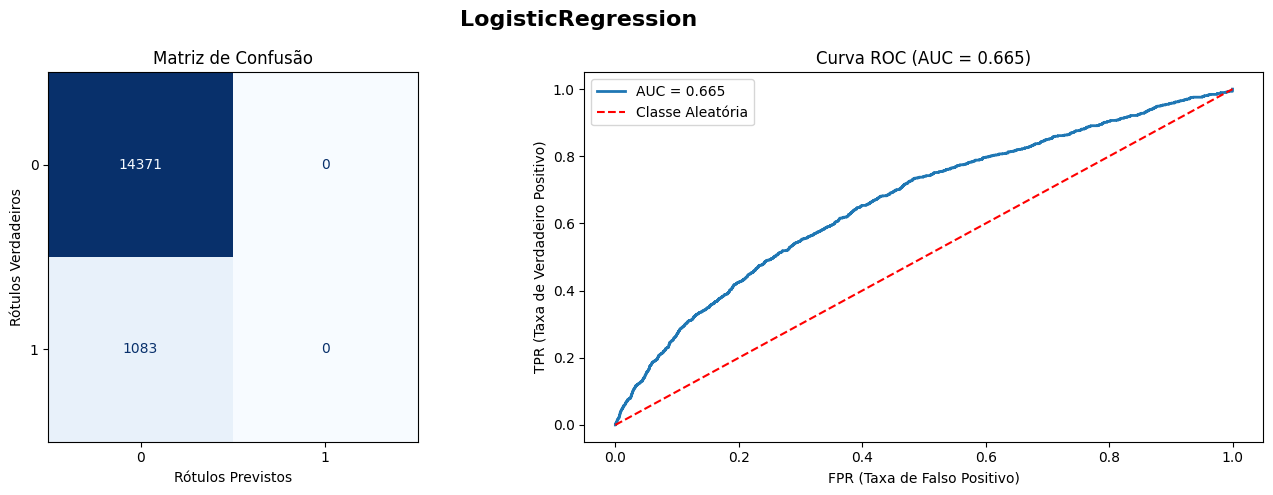

(0.6654425113466877,
 array([[14371,     0],
        [ 1083,     0]]))

In [8]:
# Avaliação do Modelo LogisticRegression
avaliar_modelo(logreg, X_test, y_test, titulo='LogisticRegression')

In [9]:
gerar_classification_report(modelo_logreg, X_test, y_test)

,precision,recall,f1-score,support
0,0.93,1.00,0.96,14371.00
1,0.00,0.00,0.00,1083.00
accuracy,0.93,0.93,0.93,0.93
macro avg,0.46,0.50,0.48,15454.00
weighted avg,0.86,0.93,0.90,15454.00


## 1.1 Interpretando os Resultados
Analisando a **Matriz de Confusão do Modelo LogisticRegression**, temos que: 

**Classe 0 (majoritária)**
- O modelo acertou 14.352 casos de classe 0.
- Não errou nenhum caso como classe 1.

**Classe 1 (minoritária)**
- ERROU TODOS os casos de classe 1.
- Foram previstos como classe 0.

O modelo está totalmente enviesado para a classe 0. Isso é típico em datasets desbalanceados, onde a classe 0 é muito mais frequente.

O comportamento real:
- O modelo prevê SEMPRE 0.
- O modelo não consegue identificar a classe 1.

---

Agora quando vemos o gráfico da **Curva de ROC**, temos que:
- A curva azul é a performance real do modelo.
- A linha vermelha tracejada é um modelo totalmente aleatório.

O Valor registrado pela Curva de ROC:**AUC = 0.664**, indica que:
- O modelo tem alguma capacidade de separação.
- Mas ainda está longe de bom (AUC > 0.80 seria bom).

Mesmo com um AUC relativamente razoável, o threshold padrão (0.5) faz com que o modelo NUNCA preveja 1.

> Por que a ROC parece boa mas o modelo prevê só 0?
> - O AUC avalia o modelo como função score, usando predict_proba().
> - A decisão final depende do threshold = 0.5.

**Provavelmente:**
1. O modelo produz probabilidades entre 0.10 e 0.40 para a classe 1
2. Mas nenhuma ultrapassa 0.5, então tudo vira 0.

**Conclusão Geral**

A curva ROC diz que o modelo tem algum poder discriminativo

# 2 Random Forest

In [10]:
# Treino do Modelo RandomForestClassifier
forest = RandomForestClassifier()
modelo_forest, y_pred_forest, acuracia_forest = treinar_modelo(forest, X_train, y_train, X_test, y_test)

Acurácia do modelo RandomForestClassifier: 0.9390


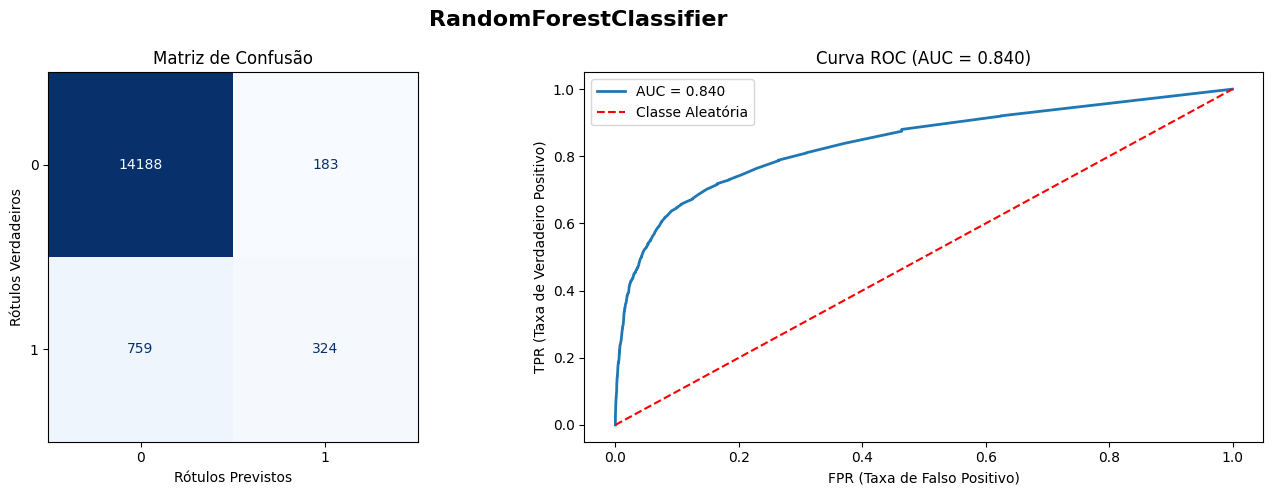

(0.8396323441207423,
 array([[14188,   183],
        [  759,   324]]))

In [11]:
# Avaliação do Modelo RandomForestClassifier
avaliar_modelo(forest, X_test, y_test, titulo='RandomForestClassifier')

In [12]:
gerar_classification_report(modelo_forest, X_test, y_test)

,precision,recall,f1-score,support
0,0.95,0.99,0.97,14371.00
1,0.64,0.30,0.41,1083.00
accuracy,0.94,0.94,0.94,0.94
macro avg,0.79,0.64,0.69,15454.00
weighted avg,0.93,0.94,0.93,15454.00


## 2.1 Interpretando os Resultados
Vamos analisar a **Matriz de Confusão do Modelo RandomForestClassifier**:

**Classe 0 (negativo)**
- 14190 verdadeiros negativos (TN): O modelo acertou quando o rótulo real era 0.
- 162 falsos positivos (FP): O modelo disse que era 1, mas na verdade era 0.

Em resumo: O modelo vai muito bem para a classe 0.

**Classe 1 (positivo)**
- 335 verdadeiros positivos (TP): O modelo acertou quando o rótulo real era 1.
- 767 falsos negativos (FN): O modelo disse que era 0, mas na verdade era 1.

Isso indica que o modelo tem mais dificuldade para identificar a classe 1. Isso é típico em datasets desbalanceados, onde a classe positiva tem poucos exemplos.

**Resumo da matriz de confusão**
- Alta performance em prever classe 0.
- Performance moderada/fraca em prever classe 1.

Provável desbalanceamento da base.

---

Analisando o gráfico da **Curva de ROC**, temos que, a curva azul mostra a relação entre:
- **TPR** (True Positive Rate) → Sensibilidade
- **FPR** (False Positive Rate)

Quanto mais a curva sobe para o canto superior esquerdo, melhor o modelo.

Na sua curva, a linha azul:
- Sobe rápido
- Fica bem acima da linha vermelha
- Chega perto do topo

Isso indica que o modelo consegue diferenciar bem entre classes 0 e 1.

O gráfico da Curva de ROC, para o RandomForestClassifier registra **AUC = 0.848**, isso mostra que o modelo é muito bom.

Para entender melhor o que esse valor representa, vamos analisar o tabela abaixo: 

| Valor AUC |                  |
| --------- | ---------------- |
| 0.5       | Modelo Aleatório |
| 0.6 - 0.7 | Fraco            |
| 0.7 - 0.8 | Razoável         |
| 0.8 - 0.9 | Muito Bom        |
| 0.9 +     | Excelente        |

O valor AUC (Area Under the Curve) mede a qualidade geral do modelo.


Mesmo com dificuldade em prever classe 1 (visto na matriz de confusão), o modelo tem boa separabilidade.


# 3 Árvore de Decisão

In [13]:
# Treino do Modelo DecisionTreeClassifier
arvore = tree.DecisionTreeClassifier()
modelo_arvore, y_pred_arvore, acuracia_arvore = treinar_modelo(arvore, X_train, y_train, X_test, y_test)

Acurácia do modelo DecisionTreeClassifier: 0.9112


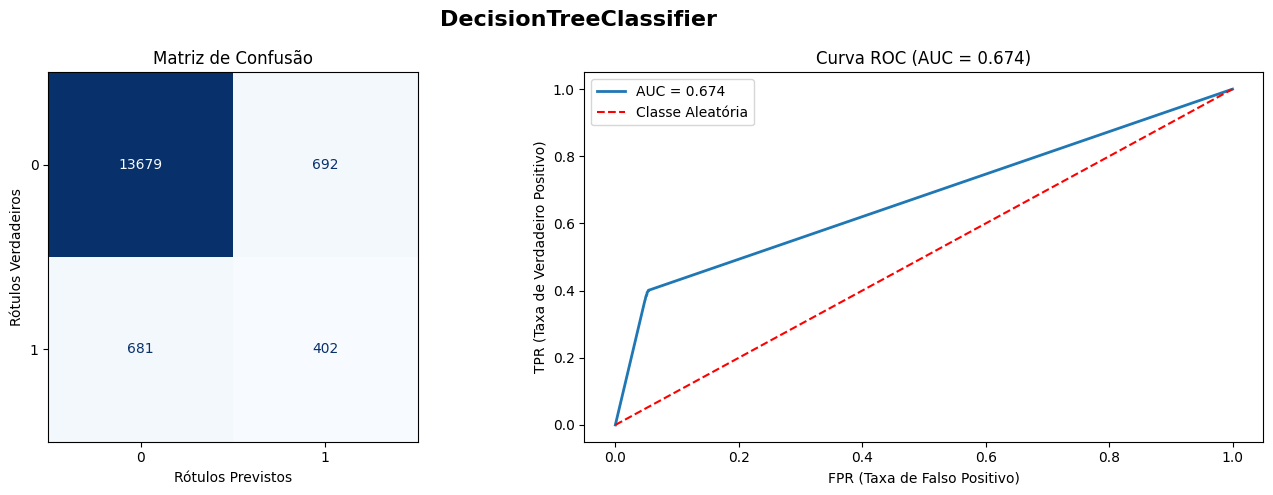

(0.6739505594812267,
 array([[13679,   692],
        [  681,   402]]))

In [14]:
# Avaliação do Modelo DecisionTreeClassifier
avaliar_modelo(arvore, X_test, y_test, titulo='DecisionTreeClassifier')

In [15]:
gerar_classification_report(modelo_arvore, X_test, y_test)

,precision,recall,f1-score,support
0,0.95,0.95,0.95,14371.00
1,0.37,0.37,0.37,1083.00
accuracy,0.91,0.91,0.91,0.91
macro avg,0.66,0.66,0.66,15454.00
weighted avg,0.91,0.91,0.91,15454.00


## 3.1 Interpretando os Resultados
Analisando a **Matriz de Confusão do Modelo DecisionTreeClassifier**, temos que:

**Classe 0 (negativo)**
- O modelo acertou 13.645 casos realmente da classe 0.
- O modelo classificou 707 casos da classe 0 como se fossem classe 1.

**Classe 1 (positivo)**
- O modelo acertou 380 casos realmente da classe 1.
- O modelo classificou 722 casos da classe 1 como se fossem classe 0.

Isso significa que o Modelo de DecisionTreeClassifier (Árvore de Decisão):
- Acerta muito bem a classe 0, pois 13.645 acertos contra 707 erros.

- Tem dificuldade com a classe 1, pois acerta apenas 380 casos e erra 722.

Ou seja, sensibilidade (recall da classe 1) é baixa.

Esse é um comportamento típico quando: a classe 1 é minoria (dataset desbalanceado), logo, modelos que Árvode de Decisão tendem a priorizar a classe mais frequente.

---

Analisando o gráfico da **Curva de ROC**, vemos que:
- **AUC = 0.660** - modelo fraco, próximo do limite entre "ruim" e "aceitável".

**Significa** que: O modelo tem 66% de chance de rankear um positivo acima de um negativo.
- O modelo não diferencia bem as classes.
- A árvore se enquadra em um nível de desempenho fraco.
- Está coerente com a matriz de confusão, que mostra dificuldade em classificar a classe 1.
- O dataset provavelmente é desbalanceado


# 4 KNeighborsClassifier

In [16]:
# Treino do Modelo KNeighborsClassifier
knn = KNeighborsClassifier()
modelo_knn, y_pred_knn, acuracia_knn = treinar_modelo(knn, X_train, y_train, X_test, y_test)

Acurácia do modelo KNeighborsClassifier: 0.9310


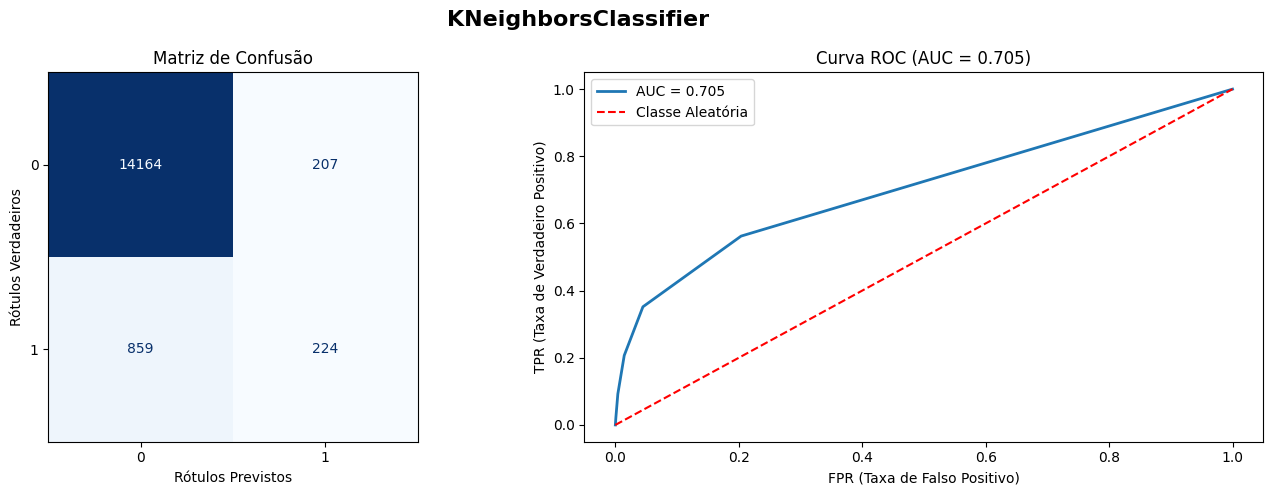

(0.7049084050398254,
 array([[14164,   207],
        [  859,   224]]))

In [17]:
# Avaliação do Modelo KNeighborsClassifier
avaliar_modelo(knn, X_test, y_test, titulo='KNeighborsClassifier')

In [18]:
gerar_classification_report(modelo_knn, X_test, y_test)

,precision,recall,f1-score,support
0,0.94,0.99,0.96,14371.00
1,0.52,0.21,0.30,1083.00
accuracy,0.93,0.93,0.93,0.93
macro avg,0.73,0.60,0.63,15454.00
weighted avg,0.91,0.93,0.92,15454.00


## 4.1 Interpretando os Resultados
Analisando a Matriz de Confusão do Modelo KNeighborsClassifier, vemos que:

**Classe 0 (negativo)**
- Verdadeiros Negativos (TN) classificou 14140 casos 0 prevista como 0 corretamente.
- Falsos Positivos (FP) classificou 221 casos 0 prevista como 1 (modelo produz um “alarme falso”).

**Classe 1 (positivo)**
- Verdadeiros Positivos (TP) classifocu 235 casos 1 prevista como 1 corretamente.
- Falsos Negativos (FN) classificou 867 casos 1 prevista como 0 (modelo deixa passar casos da classe positiva).

Isso mostra que 
- O modelo acerta MUITO BEM a classe 0
- 14140 acertos vs apenas 212 erros.

O modelo tem dificuldade com a classe 1
- Apenas 235 acertos vs 867 erros.
- Isso significa que ele não consegue identificar bem os positivos.

Este padrão é comum no KNN quando:
- o dataset é desbalanceado,
- os vizinhos mais próximos majoritários são da classe 0.

---

Analisando o gráfico da **Curva de ROC**, podemos ver que o valor **AUC = 0.708** está entre 0.7 e 0.8 é considerado modelo Razoável/OK, mas não excelente. Significa que existe 70,8% de chance do modelo rankear corretamente um positivo acima de um negativo. O modelo tem capacidade moderada de separação das classes.

**Conclusão Geral**
- Pontos positivos:
    - O modelo acerta muito bem a classe 0.
    - AUC de 0.708 indica que o modelo tem alguma habilidade discriminativa.

- Pontos negativos:
    - Ele erra bastante a classe positiva (1).
    - 867 falsos negativos é um valor alto.


# Análise Preliminar
Vimos que os quatro modelos escolhidos performam de forma distintas, sendo o Random Forest com a melhor performance seguido do Kneighbor, entretando temos um problema crônico no dataset que afetas todos os modelos aqui testados: **DESBALANCEAMENTO DO DATASET**, afetando significativamente o resultado final.

Vamos buscar estrátegias que minizem esse problema.

# LightGBM
LightGBM significa Light Gradient Boosting Machine é um framework de boosting de gradiente desenvolvido pela Microsoft, conhecido por sua eficiência e velocidade. Ela é eficiente e robusta no tratamento de dados desbalanceados e oferece mecanismos integrados para isso.
O LightGBM pode lidar com o desbalanceamento diretamente através de seus parâmetros ou métodos de amostragem inteligentes. 

In [19]:
# Importanto a biblioteca do Lightgbm
import lightgbm as lgb

In [20]:
# Treino do Modelo Lightgbm
classificador_lgbm = lgb.LGBMClassifier()
modelo_lgb, y_pred_lgb, acuracia_lgb = treinar_modelo(classificador_lgbm, X_train, y_train, X_test, y_test)

[LightGBM] [Info] Number of positive: 4322, number of negative: 57491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 61813, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069921 -> initscore=-2.587910
[LightGBM] [Info] Start training from score -2.587910
Acurácia do modelo LGBMClassifier: 0.9365


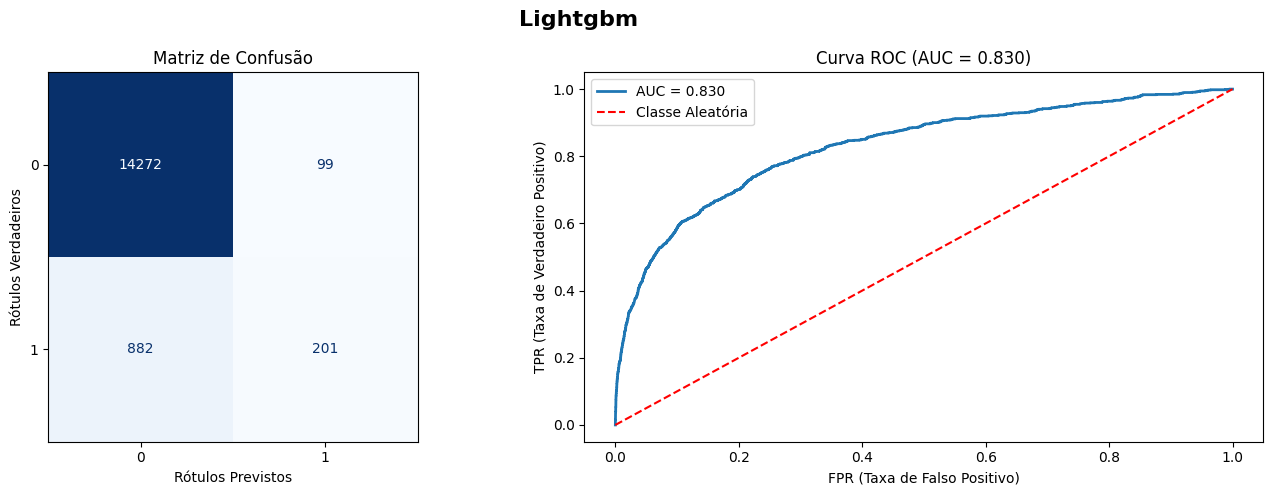

(0.829502904594015,
 array([[14272,    99],
        [  882,   201]]))

In [21]:
# Avaliação do Modelo Lightgbm
avaliar_modelo(classificador_lgbm, X_test, y_test, titulo='Lightgbm')

In [22]:
gerar_classification_report(classificador_lgbm, X_test, y_test)

,precision,recall,f1-score,support
0,0.94,0.99,0.97,14371.00
1,0.67,0.19,0.29,1083.00
accuracy,0.94,0.94,0.94,0.94
macro avg,0.81,0.59,0.63,15454.00
weighted avg,0.92,0.94,0.92,15454.00


Analisando a Matriz de Confusão do Modelo Lightgbm, vemos que:

**Classe 0 (negativo)**
- Verdadeiros Negativos (TN) classificou 14244 casos 0 prevista como 0 corretamente.
- Falsos Positivos (FP) classificou 97 casos 0 prevista como 1 (modelo produz um “alarme falso”).

**Classe 1 (positivo)**
- Verdadeiros Positivos (TP) classifocu 216 casos 1 prevista como 1 corretamente.
- Falsos Negativos (FN) classificou 897 casos 1 prevista como 0 (modelo deixa passar casos da classe positiva).

Isso mostra que 
- O modelo acerta MUITO BEM a classe 0

É possível averiguar que ainda temos dificuldade em classificar os casos 0 e 1


In [ ]:
# Proporção das variáveis target
df_treino['INADIMPLENCIA'].value_counts(normalize=True)*100

INADIMPLENCIA
0    93.004776
1     6.995224
Name: proportion, dtype: float64

Na nossa base de dados 93% deles são de Não-Inadimplentes, quando temos uma situação dessa o modelo tende a priorizar a detecção da classe majoritária. Mesmo assim os modelos: 
- RandomForestClassifier;
- Lightgbm

Foram os que tiveram melhor resultado.

# Avaliando na Base de Teste
Agora irei avaliar os modelos na `base_pagamentos_teste.csv`. Irei implementar o modelo que teve melhor resultado o `RandomForestClassifier`.

In [24]:
# Separando as colunas que usarei para submissão do modelo
X_teste = teste.drop(['ID_CLIENTE', 'SAFRA_REF'], axis=1)

# Utilizando o RandomForestClassifier na base de teste
y_pred = forest.predict(X_teste)

# Calculando a probabilidade de cada evento
y_broba = forest.predict_proba(X_teste)[:,1]

# Criando um nova coluna com a brobalidade das previsões e a inadimplência na base de teste 
teste['Inadimplencia'] = y_pred
teste['Probalidade %'] = y_broba

# Criando o dataset para submissão
sub = teste[['ID_CLIENTE', 'SAFRA_REF', 'Probalidade %']]

In [25]:
display(sub)

,ID_CLIENTE,SAFRA_REF,Probalidade %
0,5058298901476893676,2021-07,0.06
1,274692171162531764,2021-07,0.02
2,274692171162531764,2021-07,0.21
3,274692171162531764,2021-07,0.07
4,465309249432033993,2021-07,0.00
...,...,...,...
12270,705648002974742140,2021-11,0.00
12271,4993499380140734678,2021-11,0.01
12272,4614484019183480654,2021-11,0.23
12273,1299146298565441811,2021-11,0.00


In [26]:
# Salvando o dataset 
sub.to_csv('docs/submissao.csv', index=False)

# Grupo de Risco
O grupo de risco de inadimplência refere-se a indivíduos ou empresas que apresentam uma alta probabilidade de não cumprirem com suas obrigações financeiras dentro dos prazos estipulados. Essa probabilidade é determinada por meio de análises de crédito que consideram diversos fatores e indicadores. 

In [28]:
from sklearn import preprocessing

In [29]:
# Calculando a probabilidade de cada evento
y_broba_forest = forest.predict_proba(X_test)[:,1]

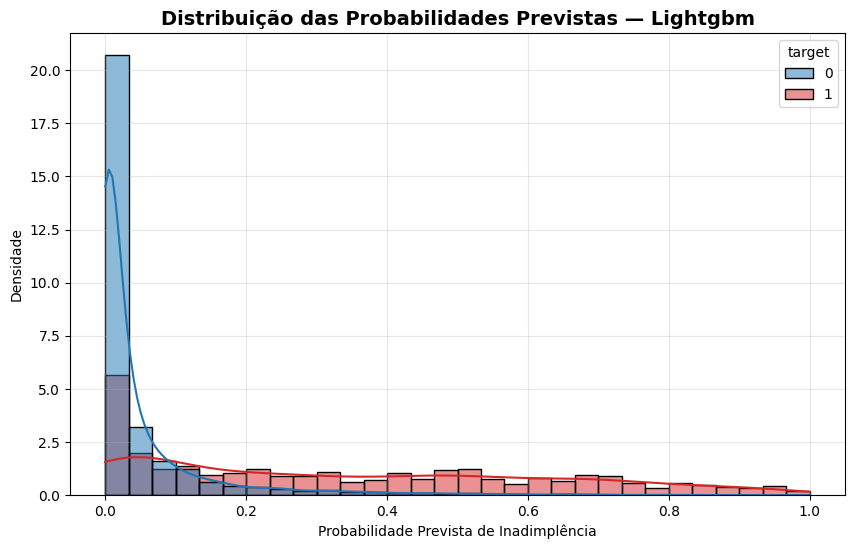

In [30]:

# Criar dataframe auxiliar para facilitar
df_plot = pd.DataFrame({
    "probabilidade": y_broba_forest,
    "target": y_test.reset_index(drop=True)
})

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_plot,
    x="probabilidade",
    hue="target",
    bins=30,
    kde=True,
    stat="density",
    common_norm=False,  # muito importante: não normalizar junto as classes!!
    palette=["#1f77b4", "#d62728"]  # azul (0) e vermelho (1)
)

plt.title("Distribuição das Probabilidades Previstas — Lightgbm", fontsize=14, fontweight="bold")
plt.xlabel("Probabilidade Prevista de Inadimplência")
plt.ylabel("Densidade")
plt.grid(alpha=0.3)
plt.show()

A distribuição de probabilidades prevista ela não tem variabilidade, os valores previstos são bem próximos uns dos outros. No nosso projeto o modelo que teve melhor resultado foi o Random Forest que tem como caracterísitica de não gerar probabilidades contínuas, mas sim probabilidades discretas, ou seja, poucos **valores únicos**.

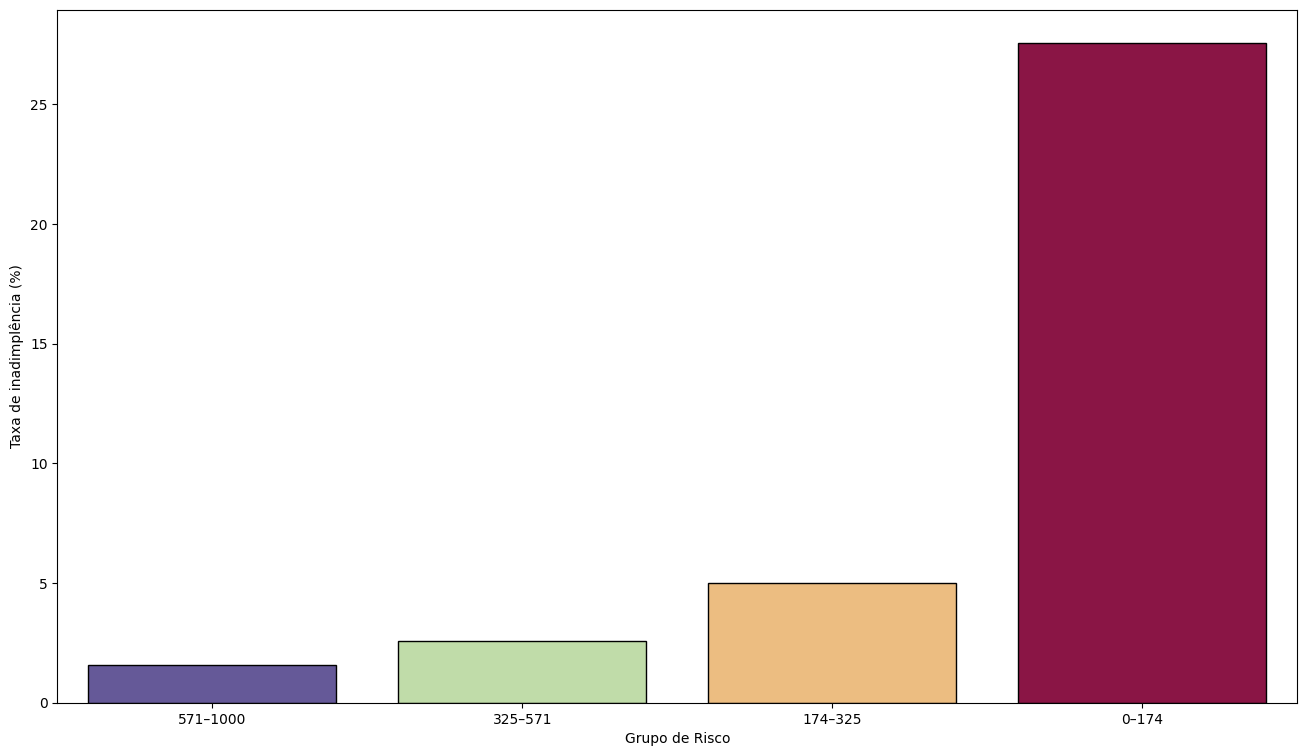

In [31]:
# QuantileTransformer transforma as probabilidades previstas em distribuição uniforme.
qt = preprocessing.QuantileTransformer(random_state=42)
score_model = np.round(
    (1 - qt.fit_transform(y_broba_forest.reshape(-1, 1))) * 1000, 0
)

# Cria quartis (4 grupos de risco) com base na distribuição dos scores
lista_scores_test = score_model.flatten().tolist()
prob_test_cat, bin_edges = pd.qcut(
    lista_scores_test, q=6,retbins=True, labels=False, duplicates="drop"
)

# Monta o DataFrame com score e target
scores_test = pd.DataFrame(
    {"score": prob_test_cat + 1, "target": y_test}  # grupos 1, 2, 3, 4
)

# Calcula a taxa de inadimplência (%) por grupo
scores_test_grouped = (scores_test.groupby("score")["target"].mean() * 100).round(2)

# Arredonda limites dos bins para exibir nos rótulos do eixo x
bin_edges_int = np.round(bin_edges).astype(int)

# Criação do gráfico
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(
    x=scores_test_grouped.index,
    y=scores_test_grouped.values,
    hue=scores_test_grouped.index,
    palette="Spectral",
    edgecolor="k",
    legend=False,
    ax=ax,
)

# Rótulos de eixo x correspondentes aos intervalos de score
ax.set_xticks(range(len(scores_test_grouped)))
ax.set_xticklabels(
    [f"{bin_edges_int[i]}–{bin_edges_int[i+1]}" for i in range(len(bin_edges_int) - 1)]
)

# Inverte o eixo x para que o grupo de maior risco (menor score) fique à esquerda
ax.invert_xaxis()

ax.set_xlabel("Grupo de Risco")
ax.set_ylabel("Taxa de inadimplência (%)")

plt.show()

Nesse gráfico, temos um problema que o Random Forest ao calcular as probabilidades gera valores discretos, isso acaba afetando na divisão dos grupos de riscos, quando pedimos no código para gera um dataframe usando `qcut` ela vai mesclar os valores muito próximos. Quando duas ou mais fronteiras de cortes ficam com valores iguais, o `qcut` não consegue criar intervalos distintos.

# SHAP do Modelo
O SHAP (SHapley Additive exPlanations) é uma metodologia essencial de Inteligência Artificial Explicável, é usada para interpretar e tornar transparentes as decisões de modelos complexos de machine learning. Ele quantifica a contribuição de cada variável de entrada para uma previsão específica do modelo. Ele atribui um valor de importância, chamado "valor SHAP", a cada característica, que representa o impacto que essa característica teve na saída do modelo em comparação com uma previsão média (linha de base). 

In [32]:
# Importando o SHAP
import shap

shap.initjs()

In [33]:
# Cálculo dos valores shape do Modelo
explainer = shap.Explainer(forest.predict, X_test)

In [ ]:
# O cálculo do SHAP pode levar um certo tempo. (aproximadamente 15 minutos)
shap_values = explainer(X_test)

ExactExplainer explainer: 15455it [13:53, 18.42it/s]                           


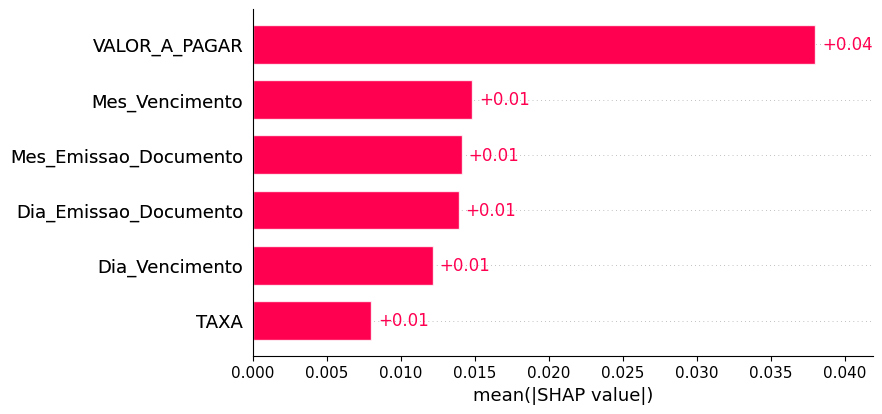

In [28]:
shap.plots.bar(shap_values)

Esse gráfico mostra as características que tiveram maior impacto na previsão para a que tem menor impacto. Leva-se em consideração o valor absoluto do SHAP, portanto, não importa se a característica afeta a previsão de forma positiva ou negativa.

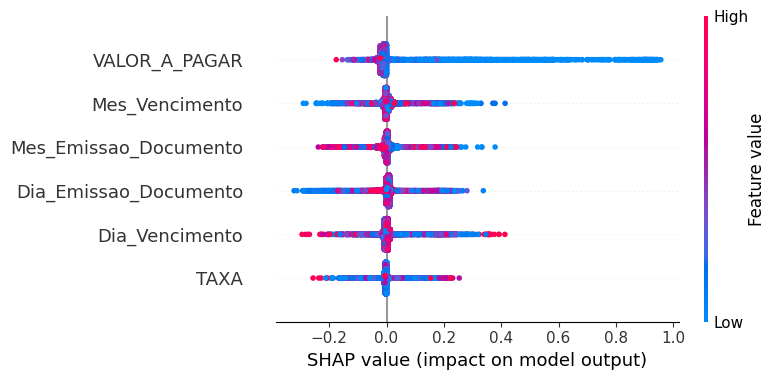

In [29]:
shap.summary_plot(shap_values)

No gráfico de Enxame de Abelhas, as características também são ordenadas pelo seu efeito na previsão, mas também podemos ver como valores mais altos e mais baixos da característica afetam o resultado.

Todos os pequenos pontos no gráfico representam uma única observação. O eixo horizontal representa o valor SHAP, enquanto a cor do ponto indica se essa observação tem um valor maior ou menor em comparação com outras observações.

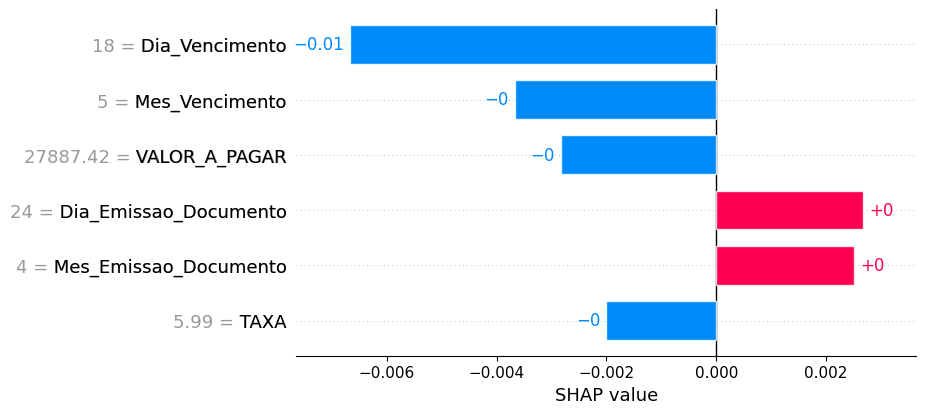

In [30]:
shap.plots.bar(shap_values[0])

Este gráfico mostra quais são as principais características que afetam a previsão de uma única observação e a magnitude do valor SHAP para cada característica.

# Conclusão
O objetivo deste projeto era construir um modelo pretidivo para prever a probabilidade de inadimplência para uma empresa de consultoria especializada em soluções de dados e inteligência de crédito. Por meio da limpeza dos dataset realizado em: [DESAFIO - PARTE I.ipynb](https://github.com/rrafahenrique/Modelo-Preditivo-Inadimplencia/blob/main/DESAFIO%20-%20PARTE%20I.ipynb), foi feita a preparação, organização e tratamento dos dados para remover erros e inconsistências.

Após essa etapa crucial foi feita a análise exploratória dos dados: [DESAFIO - PARTE II.ipynb](https://github.com/rrafahenrique/Modelo-Preditivo-Inadimplencia/blob/main/DESAFIO%20-%20PARTE%20II.ipynb), foram efetuadas interpretação dos dados para descobrir padrões, tendências e informações úteis, transformando números em insights.

Na construção do modelo [DESAFIO - PARTE III.ipynb](https://github.com/rrafahenrique/Modelo-Preditivo-Inadimplencia/blob/main/DESAFIO%20-%20PARTE%20III.ipynb), foram abordados: Regressão Logísitica, Random Forest, Árvore de Decisão e KNeighbors, foi observado problemas de classificação, já que o dataset possui uma classe majoritária que se sobressai da outra, comportamento clássico de dataset desbalanceado. Detectado esse problema, foi escolhido outro modelo, o LightGBM, muito utilizado em modelos com dataset desbalanceado. 

Em resumo, o modelo treinado com Random Florest foi o que teve melhor resultado, mesmo com o problema de desbalanceamos dos dados. Como sugestão a empresa fictícia deste projeto definir o cutoff que otimiza a função de lucro da empresa ao invés de apenas usar métricas como acurácia ou AUC. Essa etapa envolve simular o lucro potencial para uma série de valores de limite de classificação e escolher o que gera o maior retorno financeiro, para isso é recomendado consultar a área de negócio da empresa.